For an up-to-date version / full view of the plotly - plots, please, go to

EDA: https://drive.google.com/file/d/19tQcpwYM8aNWtaAtDHlwleMyqQSlmpAM/view?usp=sharing

# LendingClub Prediction: EDA


## Import Modules

In [1]:
%%capture
! pip install -q pingouin
! pip install -q fastparquet==2024.2.0
! pip install -q dask==2023.8.1

! pip install -q pandas==1.5.3

In [2]:
import numpy as np
import pandas as pd

import sys
import os
import warnings
from importlib import reload

from dask import dataframe as dd
#import matplotlib.pyplot as plt
#import seaborn as sns
#import plotly.express as px

#from statsmodels.stats.proportion import proportions_ztest
import pingouin as pg



from google.colab import drive
drive.mount("/content/gdrive")

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_rows')

Mounted at /content/gdrive


In [3]:
pd.__version__

'1.5.3'

In [4]:
home_folder = '/content/gdrive/MyDrive/Colab Notebooks/Portfolio/ML_LendingClub/'

### Functions

The Python-file with the functions is at
https://drive.google.com/file/d/1JWLo8HAhUdu5xkDG4-tu7MiUSLgSxOjQ/view?usp=sharing

In [5]:
%load_ext autoreload
%autoreload 2

sys.path.append(home_folder)
import lendfunc as lfunc

# EDA

EDA:
- Statistical Overview
- Distributions of Parameters
- Correlation of features
- Scatterplots of numerical features against each other
- Hypothesis Tests to assess the significance of the features


EDA-obectives:?

What do we know about the borrower before we decide for accepting or rejecting the loan request?

* possible predictors for accepted/rejected loans based on
  * accepted/rejected tables common features or based on for Fully Paid vs Charged Off (more features on borrower's liquidity prior to loan application)

What do we know about the borrower before we can assign him/her a grade and interest rate?

* possible predictors for the grade for the loan.

* possible predictors for the subgrade and the interest rate.

---> discard all parameters related a running payments of the loan and status.


## Domain Knowledge

The features in the data set are:
(https://medium.com/@kguruswamy_37814/building-ai-ml-models-on-lending-club-data-with-h2o-ai-part-1-af39245fb481)

In [6]:
LCacc_desc = pd.read_csv(home_folder+'LC_features.csv')
LCacc_desc

loan_feature  \
0                                acc_now_delinq   
1                          acc_open_past_24mths   
2                                    addr_state   
3                                      all_util   
4                                    annual_inc   
5                              annual_inc_joint   
6                              application_type   
7                                   avg_cur_bal   
8                                bc_open_to_buy   
9                                       bc_util   
10                     chargeoff_within_12_mths   
11                      collection_recovery_fee   
12                   collections_12_mths_ex_med   
13                                  delinq_2yrs   
14                                  delinq_amnt   
15                                         desc   
16                                          dti   
17                                    dti_joint   
18                             earliest_cr_line   
19                                   emp_length   
20                                    emp_title   
21                              fico_range_high   
22                               fico_range_low   
23                                  funded_amnt   
24                              funded_amnt_inv   
25                                        grade   
26                               home_ownership   
27                                           id   
28                                      il_util   
29                          initial_list_status   
30                                       inq_fi   
31                                 inq_last_12m   
32                               inq_last_6mths   
33                                  installment   
34                                     int_rate   
35                                      issue_d   
36                           last_credit_pull_d   
37                         last_fico_range_high   
38                          last_fico_range_low   
39                              last_pymnt_amnt   
40                                 last_pymnt_d   
41                                    loan_amnt   
42                                  loan_status   
43                                   max_bal_bc   
44                                    member_id   
45                           mo_sin_old_il_acct   
46                         mo_sin_old_rev_tl_op   
47                        mo_sin_rcnt_rev_tl_op   
48                               mo_sin_rcnt_tl   
49                                     mort_acc   
50                       mths_since_last_delinq   
51                  mths_since_last_major_derog   
52                       mths_since_last_record   
53                           mths_since_rcnt_il   
54                         mths_since_recent_bc   
55                     mths_since_recent_bc_dlq   
56                        mths_since_recent_inq   
57               mths_since_recent_revol_delinq   
58                                 next_pymnt_d   
59                        num_accts_ever_120_pd   
60                               num_actv_bc_tl   
61                              num_actv_rev_tl   
62                                  num_bc_sats   
63                                    num_bc_tl   
64                                    num_il_tl   
65                                num_op_rev_tl   
66                                num_rev_accts   
67                          num_rev_tl_bal_gt_0   
68                                     num_sats   
69                             num_tl_120dpd_2m   
70                                 num_tl_30dpd   
71                           num_tl_90g_dpd_24m   
72                           num_tl_op_past_12m   
73                                     open_acc   
74                                  open_acc_6m   
75                                  open_il_12m   
76                                  open_il_24m   
77                                  open_act_il   
78    

## Load Cleaned Data

In [7]:
parquet_home_acc_cleaned = home_folder+'parquet_LCacc_cleaned/'
parquet_home_rej_cleaned = home_folder+'parquet_LCrej_cleaned/'

In [8]:
LCacc_dd = dd.read_parquet(parquet_home_acc_cleaned, ignore_metadata_file=True)
LCrej_dd = dd.read_parquet(parquet_home_rej_cleaned, ignore_metadata_file=True)

In [9]:
size_acc_dd = len(LCacc_dd)
size_rej_dd = len(LCrej_dd)
acc_rej_size_ratio = size_acc_dd/size_rej_dd

In [10]:
acc_rej_size_ratio = size_acc_dd/size_rej_dd
round(acc_rej_size_ratio,3)

0.078

## Application Status (Accepted vs Rejected; Target)

#### Create joint sample for Loan Applications

In [11]:
rej_cols = ['Amount Requested', 'Risk_Score', 'Zip Code', 'State',
       'Employment Length', 'applied_year', 'dti']

In [12]:
acc_cols = ['loan_amnt', 'fico_range_high', 'zip_code', 'addr_state',
       'emp_length', 'issue_d_year', 'dti']

In [13]:
rename_map={}
for rej, acc in zip(rej_cols, acc_cols):
    rename_map[acc] = rej

In [14]:
rejSAMPLES = 10000
frac_rej = rejSAMPLES/size_rej_dd

LCrej_dd_EDA_app =LCrej_dd[rej_cols].sample(frac=frac_rej, replace=False, random_state=10)
LCrej_dd_EDA_app['App_Status'] = 'rejected'

In [15]:
accSAMPLES = rejSAMPLES * acc_rej_size_ratio
frac_acc = accSAMPLES/size_acc_dd

LCacc_dd_EDA_app =LCacc_dd[acc_cols].sample(frac=frac_acc, replace=False, random_state=10)
LCacc_dd_EDA_app['App_Status'] = 'accepted'

In [16]:
LCrej_EDA_app = LCrej_dd_EDA_app.compute()
len(LCrej_EDA_app)

10002

In [17]:
LCacc_EDA_app = LCacc_dd_EDA_app.compute()
len(LCacc_EDA_app)

779

In [18]:
LCacc_EDA_app.rename(columns=rename_map, inplace=True)

In [19]:
LCapp_EDA = pd.concat([LCrej_EDA_app, LCacc_EDA_app], axis=0)
LCapp_EDA.reset_index(inplace=True, drop=True)

In [20]:
len(LCapp_EDA)

10781

In [21]:
LCapp_EDA.to_csv(home_folder+'cleaned/LendingClub_app_EDA.csv', index=False)

### Data Aggregations (Full Data)

The amount of missing risk scores varies over time - worth to look at it:

In [22]:
LCrej_dd_year_all = LCrej_dd['applied_year'
                            ].value_counts(sort=False)
LCrej_dd_year_noRS = LCrej_dd.loc[LCrej_dd.Risk_Score.isna()
                                 ]['applied_year'
                                 ].value_counts(sort=False)

LCrej_year_noRS_perc = LCrej_dd_year_noRS / LCrej_dd_year_all * 100
LCrej_year_noRS_perc = LCrej_year_noRS_perc.compute().to_frame()
LCrej_year_noRS_perc.reset_index(inplace=True)
LCrej_year_noRS_perc.rename(inplace=True,
                               columns={'applied_year': 'no Risk Score [%]',
                                        'index': 'Year_applied'}
                               )

Aggregate Rejected:

In [23]:
LCrej_year = LCrej_dd.select_dtypes(include='number').groupby(by='applied_year'
                            ).agg(Counts = ('Amount Requested', 'size'),
                                  Amount_Requested = ('Amount Requested', 'mean'),
                                  Risk_Score = ('Risk_Score', 'mean'),
                                  DtI = ('dti', 'mean')
                                  ).compute()

LCrej_year.reset_index(inplace=True)
LCrej_year['App_Status'] = 'rejected'

Aggregate Accepted:

In [24]:
#LCacc_dd_select = LCacc_dd[['issue_d_year','loan_amnt', 'fico_range_high', 'dti']]
#LCacc_dd_select = LCacc_dd_select.loc[~LCacc_dd_select.isna()]

In [25]:
#LCacc_dd_select.head()

In [26]:
LCacc_year = LCacc_dd.groupby(by='issue_d_year',
                            ).agg(Counts = ('loan_amnt', 'size'),
                                  Amount_Requested = ('loan_amnt', 'mean'),
                                  Risk_Score = ('fico_range_high', 'mean'),
                                  DtI = ('dti', 'mean')
                                  ).compute()

LCacc_year.reset_index(inplace=True)
LCacc_year['App_Status'] = 'accepted'
LCacc_year.rename(inplace=True,
                 columns={'issue_d_year': 'applied_year'}
                 )
#LCacc_year.round(1)

Merge Aggregates:

In [27]:
LC_year = pd.concat([LCacc_year, LCrej_year])
LC_year = LC_year.sort_values(by=['applied_year', 'App_Status'])
LC_year.rename(inplace=True,
                 columns={'applied_year': 'Year_applied'})
#LC_year.round(1)

### Bar Charts

In [28]:
map_order = {'App_Status': ['accepted', 'rejected']}

In [29]:
df = LC_year

x_col = 'Year_applied'
cols = ['Counts', 'Amount_Requested', 'Risk_Score', 'DtI']
hue = 'App_Status'
titles = ['Absolute Amount of Applications', 'Mean Requested Loan',
          'Mean Risk Score', 'Mean Debt to Income Ratio (DtI)']
legend_posis = ['Left', 'Right_b', 'Right_b', 'Right']


for col, title, legend_pos in zip(cols, titles, legend_posis):
    lfunc.bar_plot(df, x=x_col, y = col,
             hue = hue,
             legend_pos = legend_pos,
             title = title,
             category_order = map_order)

In [30]:
df = LCrej_year_noRS_perc

x_col = 'Year_applied'
cols = ['no Risk Score [%]']
hue = None #'App_Status'
titles = ['Missing Risk Score in %']
legend_posis = ['Right_b']

for col, title, legend_pos in zip(cols, titles, legend_posis):
    lfunc.bar_plot(df, x=x_col, y = col,
             hue = hue,
             legend_pos = legend_pos,
             title = title)

### Distributions per Feature in Sample Data

In [31]:
LCapp_EDA.columns

Index(['Amount Requested', 'Risk_Score', 'Zip Code', 'State',
       'Employment Length', 'applied_year', 'dti', 'App_Status'],
      dtype='object')

In [32]:
%reload_ext autoreload

df = LCapp_EDA.astype('object')

feature_app = ['Amount Requested', 'Risk_Score',
              'applied_year', 'dti']

feat_trans = feature_app
hue = 'App_Status'
names = feat_trans

bins =[80, 160, 20, 80]

lfunc.quick_histogram(df, feat_trans, names, bins=bins, ranges_x = None,
                      hue = hue, name_replace='underscore')

Let's have a look at the logarithmic version of the feature above:

In [33]:
df = LCapp_EDA

log_num_feat_app = []
for feat in feature_app:
    df[feat+'_log'] = np.log(df[feat])
    log_num_feat_app.append(feat+'_log')

In [34]:
LCapp_EDA.replace([np.inf, -np.inf], np.nan, inplace=True)

In [35]:
%reload_ext autoreload

df = LCapp_EDA.astype('object')

feat_trans = log_num_feat_app
hue = 'App_Status'
names = feat_trans

bins =[40, 40, 20, 40]

lfunc.quick_histogram(df, feat_trans, names, bins=bins, ranges_x = None,
                      hue = hue, name_replace='underscore')

### Pie Charts

##### Aggregates for Pie Charts

In [36]:
dask_df_acc = LCacc_dd
dask_df_rej = LCrej_dd

dfs_acc = []
dfs_rej = []

cat_feat_pie_acc = ['addr_state', 'emp_length']
cat_feat_pie_rej = ['State','Employment Length']

for feat in cat_feat_pie_acc:
    df_group = dask_df_acc.groupby(by=[feat]
                               )[feat
                               ].count().compute().to_frame().rename(
                                  columns={feat: 'counts'})
    df_group.reset_index(inplace=True)
    df_group['App_Status'] = 'accepted'
    dfs_acc.append(df_group)

for feat in cat_feat_pie_rej:
    df_group = dask_df_rej.groupby(by=[feat]
                               )[feat
                               ].count().compute().to_frame().rename(
                                  columns={feat: 'counts'})
    df_group.reset_index(inplace=True)

    df_group['App_Status'] = 'rejected'
    dfs_rej.append(df_group)

In [37]:
dfs_app = []
for df_rej, df_acc in zip(dfs_rej, dfs_acc):
    rej_cols = df_rej.columns
    acc_cols = df_acc.columns
    rename_map={}
    for rej, acc in zip(rej_cols, acc_cols):
        rename_map[acc] = rej
    df_acc.rename(columns=rename_map, inplace=True)
    df_app = pd.concat([df_rej, df_acc], axis=0)
    df_app.reset_index(inplace=True, drop=True)
    dfs_app.append(df_app)

#### Employment Length

In [38]:
cat_features = cat_feat_pie_rej
hue = 'App_Status'
titles = cat_features

In [39]:
%reload_ext autoreload

i=1
lfunc.pie_and_multicol_pie(dfs_app[i], feat = cat_features[i], hue = hue,
                           counts = 'counts', title = cat_features[i])

## Accepted

### Data Selection by Loan Status (Charged Off vs Fully Paid)

Default = beyond "late" period = unpaid
---> short before 'charged off'?

In [40]:
original = 'loan_status'
simple = original+'_simple'

LCacc_dd[simple] = LCacc_dd[simple].astype('object')
LCacc_dd[original] = LCacc_dd[original].astype('object')

In [41]:
LCacc_PC_dd = LCacc_dd.loc[(LCacc_dd.loan_status_simple == 'Fully Paid') |
             (LCacc_dd.loan_status_simple == 'Charged Off')]

Verify that the rows picked correspond to Charged Off or Fully Paid ( - will use 'loan_status_simple' instead of 'loan_status' from now on).

In [42]:
LCacc_PC_dd[simple].value_counts().compute()

Fully Paid     1059283
Charged Off     263010
Name: loan_status_simple, dtype: int64

In [43]:
LCacc_dd[simple] = LCacc_dd[simple].astype('category')
LCacc_dd[original] = LCacc_dd[original].astype('category')

In [44]:
size_PC = len(LCacc_PC_dd)

In [45]:
accSAMPLES = 10000
frac_PC = accSAMPLES/size_PC

LCacc_PC_dd_EDA=LCacc_PC_dd.sample(frac=accSAMPLES/size_PC, replace=False, random_state=10)

In [46]:
LCacc_PC_EDA = LCacc_PC_dd_EDA.compute()
len(LCacc_PC_EDA)

9998

In [47]:
LCacc_PC_EDA.to_csv(home_folder+'cleaned/LendingClub_EDA_PC.csv', index=False)

In [48]:
cat_feat = LCacc_PC_dd.select_dtypes(exclude=np.number).columns.tolist()

For defining the categorical orders

In [49]:
map_order = {'loan_status_simple': ['Fully Paid', 'Charged Off'],
             'emp_length': ['< 1 year', '1 year', '2 years', '3 years',
                            '4 years', '5 years', '6 years', '7 years',
                            '8 years', '9 years', '10+ years']}

### Pie Charts for Categorical Features

Let's look at the feature proportions for all borrowers:

In [50]:
dask_df = LCacc_PC_dd

dfs = []
cat_feat_pie = cat_feat.copy()
cat_feat_pie.remove('loan_status_simple')
#cat_feat_pie.remove('sub_grade')

for feat in cat_feat_pie:
    df_group = dask_df.groupby(by=[feat,
                                   'loan_status_simple']
                               )[feat
                               ].count().compute().to_frame().rename(
                                  columns={feat: 'counts'})
    df_group.reset_index(inplace=True)
    dfs.append(df_group)

In [51]:
cat_features = cat_feat_pie
hue = 'loan_status_simple'
titles = cat_features

#### Terms

In [52]:
%reload_ext autoreload

i=0
lfunc.pie_and_multicol_pie(dfs[i], feat = cat_features[i], hue = hue,
                           counts = 'counts', title = cat_features[i])

#### Grade

In [53]:
%reload_ext autoreload

i=1
lfunc.pie_and_multicol_pie(dfs[i], feat = cat_features[i], hue = hue,
                           counts = 'counts', title = cat_features[i])

#### Employment Length

In [54]:
%reload_ext autoreload

i=3
lfunc.pie_and_multicol_pie(dfs[i], feat = cat_features[i], hue = hue,
                           counts = 'counts', title = cat_features[i])

#### Home Ownership

In [55]:
%reload_ext autoreload

i=4
lfunc.pie_and_multicol_pie(dfs[i], feat = cat_features[i], hue = hue,
                           counts = 'counts', title = cat_features[i])

#### Verification Status

In [56]:
%reload_ext autoreload

i=5
lfunc.pie_and_multicol_pie(dfs[i], feat = cat_features[i], hue = hue,
                           counts = 'counts', title = cat_features[i])

#### Purpose

In [57]:
%reload_ext autoreload

i=7
lfunc.pie_and_multicol_pie(dfs[i], feat = cat_features[i], hue = hue,
                           counts = 'counts', title = cat_features[i])

#### Summary

### Reduce numerical Features to Main Correlations with Interest Rate (Target)

In [58]:
df = LCacc_PC_EDA

num_feat = df.select_dtypes(include=np.number).columns.tolist()

#### Correlation with Interest Rate

Evaluate the main correlation with int_rate (and consequently sub-grade and grade) and discard cases of suspected multicolinearity (due to high similarity of the reported property, e.g. considering the last 6 months vs. 12 months vs. 24 months):

In [59]:
df = LCacc_PC_EDA[list(num_feat)]

In [60]:
%reload_ext autoreload

compare_features_pos = [['open_act_il', 'dti'],
                        ['open_rv_12m', 'open_rv_24m', 'open_acc_6m',
                         'open_il_12m', 'open_il_24m', 'acc_open_past_24mths',
                         'num_tl_op_past_12m',],
                        ['delinq_2yrs', 'num_accts_ever_120_pd','num_tl_90g_dpd_24m'],
                        ['inq_last_12m', 'inq_last_6mths', 'inq_fi', 'num_tl_op_past_12m',
                          'earliest_cr_line_year'],
                        ['all_util', 'bc_util', 'revol_util', 'il_util',
                         'total_bal_il', 'percent_bc_gt_75', 'num_actv_rev_tl',
                         'num_rev_tl_bal_gt_0', 'pub_rec_bankruptcies'],
                        ]

#, , 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0']
#['bc_util',
#[, 'pub_rec_bankruptcies']

pos_corr, kick_out_pos = lfunc.find_multicorr(df, "int_rate", compare_features_pos,
                                        cutoff=0.05, inner_corr_strength = 0.3,
                                        positive = True)
#kick_out_pos

Features correlated to target int_rate  and their strenghts:

int_rate                 1.00
all_util                 0.30
bc_util                  0.29
percent_bc_gt_75         0.28
revol_util               0.26
inq_last_6mths           0.21
inq_last_12m             0.21
num_tl_op_past_12m       0.20
acc_open_past_24mths     0.19
dti                      0.17
open_rv_12m              0.17
open_rv_24m              0.16
open_il_12m              0.16
open_acc_6m              0.16
il_util                  0.15
open_il_24m              0.14
inq_fi                   0.14
loan_amnt                0.12
earliest_cr_line_year    0.11
num_actv_rev_tl          0.08
num_rev_tl_bal_gt_0      0.08
total_bal_il             0.07
open_act_il              0.07
num_accts_ever_120_pd    0.07
pub_rec                  0.07
delinq_2yrs              0.06
pub_rec_bankruptcies     0.06
num_tl_90g_dpd_24m       0.05
dtype: float64
dti
num_tl_op_past_12m
num_accts_ever_120_pd
inq_last_12m
all_util


In [61]:
%reload_ext autoreload

compare_features_neg = [['annual_inc', 'mort_acc'],
                        ['total_bc_limit', 'total_rev_hi_lim', 'tot_hi_cred_lim', 'tot_cur_bal', 'pct_tl_nvr_dlq'],
                        ['mths_since_recent_inq', 'mo_sin_rcnt_tl'],
                        ['mo_sin_rcnt_tl',
                         'mo_sin_rcnt_rev_tl_op',
                         'mo_sin_old_il_acct',
                         'mths_since_recent_bc',
                         'mths_since_rcnt_il'],
                        ['bc_open_to_buy', 'num_bc_tl','num_bc_sats', 'num_rev_accts'],
                        ['fico_range_high', 'pct_tl_nvr_dlq']
                       ]

#'avg_cur_bal'
#['total_bc_limit', 'total_rev_hi_lim', 'tot_hi_cred_lim', 'tot_cur_bal', 'pct_tl_nvr_dlq']
#['bc_open_to_buy', , 'num_bc_tl'],
#['num_bc_sats', 'num_rev_accts']

neg_corr, kick_out_neg = lfunc.find_multicorr(df, "int_rate", compare_features_neg,
                                        cutoff=-0.05, inner_corr_strength = 0.2,
                                        positive = False)
#kick_out_neg

Features correlated to target int_rate  and their strenghts:

fico_range_high         -0.42
bc_open_to_buy          -0.36
total_bc_limit          -0.27
total_rev_hi_lim        -0.24
mths_since_recent_inq   -0.18
tot_hi_cred_lim         -0.16
mths_since_rcnt_il      -0.16
mo_sin_rcnt_tl          -0.16
mo_sin_rcnt_rev_tl_op   -0.15
mo_sin_old_rev_tl_op    -0.15
annual_inc              -0.12
mort_acc                -0.11
mths_since_recent_bc    -0.11
avg_cur_bal             -0.10
tot_cur_bal             -0.10
pct_tl_nvr_dlq          -0.10
num_bc_tl               -0.09
num_bc_sats             -0.08
mo_sin_old_il_acct      -0.08
issue_d_year            -0.07
num_rev_accts           -0.06
total_acc               -0.06
dtype: float64
annual_inc
total_bc_limit
mths_since_recent_inq
mo_sin_rcnt_tl
bc_open_to_buy
fico_range_high


In [62]:
high_corr_feat = list(pos_corr.index) + list(neg_corr.index)
kick_out = kick_out_pos + kick_out_neg

multicol_reduced_feat = high_corr_feat.copy()
for item in kick_out:
    if item in multicol_reduced_feat:
        multicol_reduced_feat.remove(item)

#high_corr_feat, kick_out, multicol_reduced_feat

The following plot shows the Spearman correlation of the left-over features. The asterisks above the correlation-coefficients denote a p-value smaller than 0.05 (*), 0.01(**), 0.001(***).

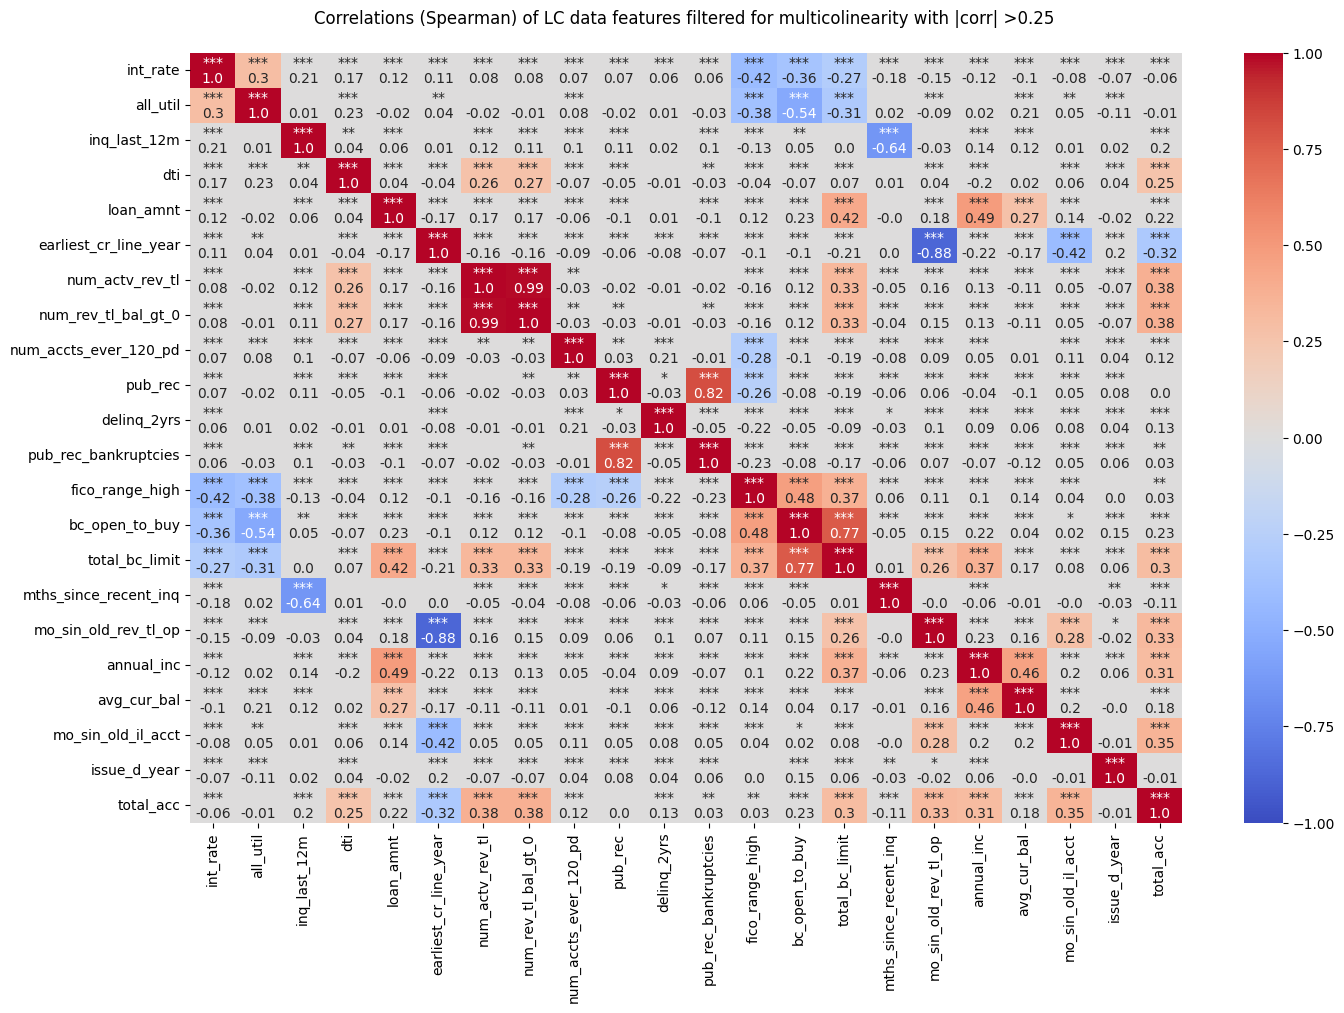

In [63]:
%reload_ext autoreload

lfunc.corr_plot_pval(df, multicol_reduced_feat, corr_method='spearman', abs_cut_off = 0.25,
                     title = '(Spearman) of LC data features filtered for multicolinearity with |corr| >')

We can use the matrix to discard multicolinearity between the selected features:

* all_util(x?) with fico_range_high
* mths_since_recent_inq'(x) with inq_last_12m
* loan_amnt with annual_inc(x): same corr strength wwith int_rate (dti should be a better proxy)
* num_accts_ever_120_pd(x) with FICO

* issue_d(x) decided to be irrelevant here

In [64]:
last_multicols = ['mths_since_recent_inq', 'all_util',
                  'num_accts_ever_120_pd', 'issue_d_year']

In [65]:
final_multicol_reduced_feat = multicol_reduced_feat.copy()
for item in last_multicols:
    if item in final_multicol_reduced_feat:
        final_multicol_reduced_feat.remove(item)

final_multicol_reduced_feat= ['int_rate','inq_last_12m','dti','loan_amnt','delinq_2yrs',
                              'pub_rec_bankruptcies','fico_range_high',
                              'annual_inc','mo_sin_old_il_acct']

print('We are left with', len(final_multicol_reduced_feat), 'numerical features.')

We are left with 9 numerical features.


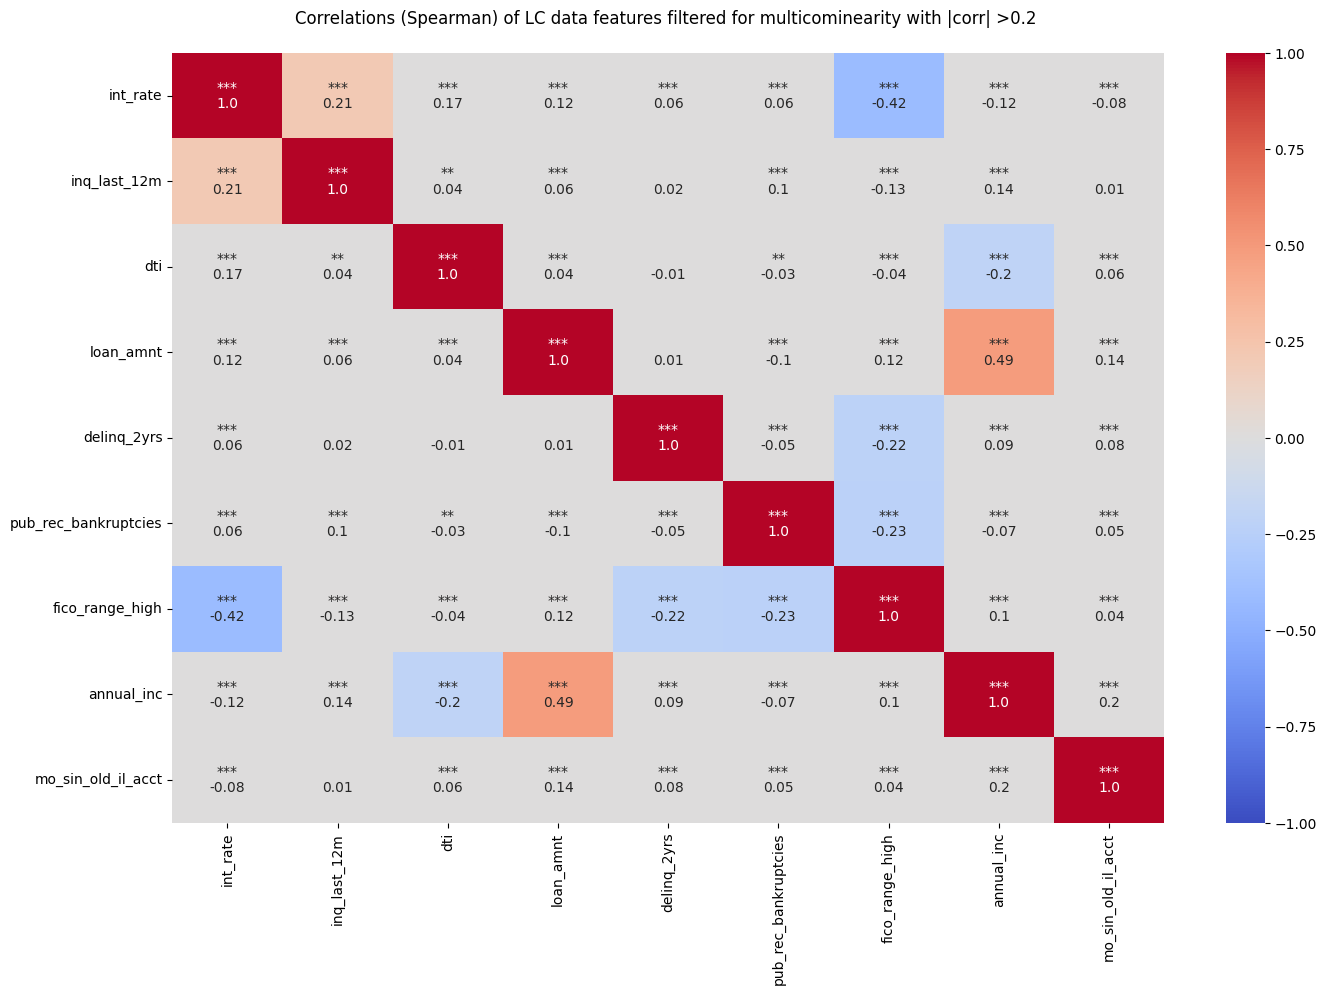

In [66]:
%reload_ext autoreload

lfunc.corr_plot_pval(df, final_multicol_reduced_feat, corr_method='spearman', abs_cut_off = 0.2,
                     title = '(Spearman) of LC data features filtered for multicominearity with |corr| >')

Note for future processing:

Next features to discard if necessary:
'annual_inc', 'delinq_2yrs', 'pub_rec_bankruptcies',

#### Interest Rate Scatter Matrix

In [67]:
#%time
%reload_ext autoreload

num_features = final_multicol_reduced_feat

df = LCacc_PC_EDA
to_scatter = num_features #[:6]
to_scatter.extend(['loan_status_simple'])

lfunc.scattermatrix(
    df,
    [to_scatter],
    colors = ['loan_status_simple'],
    titles= [""],
)

#### Distributions per Feature in Sample Data

Let's inspect the distribution of the numerical features and their transforms/composites:

In [68]:
features = final_multicol_reduced_feat


In [69]:
%reload_ext autoreload

df = LCacc_PC_EDA

feat_trans = features #[:10]
hue = 'loan_status_simple'
#bins = len(feat_trans) * [20]

names = []
for feat in feat_trans:
    name=LCacc_desc.loc[LCacc_desc.loan_feature==feat]['Description']
    names.append(name.values.tolist()[0])


bins =[40, 40, 80, 40, 20, 10, 40, 80, 80]

lfunc.quick_histogram(df, feat_trans, names, bins=bins, ranges_x = None,
                      hue = hue, name_replace='underscore')

In [70]:
df = LCacc_PC_EDA

log_num_feat = []
for feat in final_multicol_reduced_feat:
    df[feat+'_log'] = np.log(df[feat])
    log_num_feat.append(feat+'_log')

In [71]:
%reload_ext autoreload

df = LCacc_PC_EDA

feat_trans = log_num_feat #features #[:10]
hue = 'loan_status_simple'
bins = len(feat_trans) * [40]

#bins =[40, 40, 40, 40, 20, 20, 40, 20, 10, 40, 40, 40, 40]

lfunc.quick_histogram(df, feat_trans, feat_trans, bins=bins, ranges_x = None, hue = hue, name_replace='underscore')

Output hidden; open in https://colab.research.google.com to view.

##### **Summary on Full Distributions**


### Bar Charts for Selected Categorical Predictors

In [72]:
final_multicol_reduced_feat

['int_rate',
 'inq_last_12m',
 'dti',
 'loan_amnt',
 'delinq_2yrs',
 'pub_rec_bankruptcies',
 'fico_range_high',
 'annual_inc',
 'mo_sin_old_il_acct']

In [73]:
#final_multicol_reduced_feat.append('annual_inc')

In [74]:
#bar_titles = [
# 'Interest Rate',
# 'Number of Inquiries by Creditors during the past 12 Months',
# 'Debt to Income Ratio',
# 'Number of installment accounts opened in the past 12 Months',
# 'Number of revolving accounts opened in the past 12 Months',
# 'Loan Amount',
# 'Delinquencies on Lines of Credit in the last 2 Years',
# 'Number of public Record Bankruptcies',
# 'Total open to buy on Revolving Bankcards',
# 'Months since oldest Revolving Account opened',
# 'Number of Mortgage Accounts',
# 'Months since oldest Installment Account opened',
# 'Annual Income'
# ]

In [75]:
cat_feat = LCacc_PC_dd.select_dtypes(exclude=np.number).columns.tolist()
cat_feat.remove('zip_code')
cat_feat.remove('addr_state')
cat_feat.remove('loan_status')
cat_feat

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'loan_status_simple']

For defining the categorical orders

In [76]:
map_order = {'loan_status_simple': ['Fully Paid', 'Charged Off'],
             'emp_length': ['< 1 year', '1 year', '2 years', '3 years',
                            '4 years', '5 years', '6 years', '7 years',
                            '8 years', '9 years', '10+ years']}

#### Term

In [77]:
LCacc_PC_term = LCacc_PC_dd.groupby(by=['term',
                                   'loan_status_simple']
                               )[final_multicol_reduced_feat
                               ].mean().compute()
LCacc_PC_term.reset_index(inplace=True)

In [78]:
LCacc_PC_term = LCacc_PC_term.sort_values(by='annual_inc')

In [79]:
df = LCacc_PC_term

x_col = 'term'
hue = 'loan_status_simple'

cols = final_multicol_reduced_feat


title_names = []
for feat in cols:
    name=LCacc_desc.loc[LCacc_desc.loan_feature==feat]['Description'].values.tolist()[0]
    if '.' in name:
        name = name.split('.')[0]
    for prefix in ['The', 'A']:
        if name.split(' ')[0] ==  prefix:
            name = name[name.startswith(prefix) and len(prefix+' '):]
    title_names.append(name)


title_pre = 'Mean '
x_axis_title = x_col.replace('_', ' ').title()
hue_title = hue.replace('_', ' ').title()
title_suff = ' per ' + x_axis_title + ' and ' + hue_title



legend_posis = len(cols) * ['Right_b']

for col, title, legend_pos in zip(cols, title_names, legend_posis):
    lfunc.bar_plot(df, x=x_col, y = col,
             hue = hue,
             legend_pos = legend_pos,
             title = title_pre + title.title() + '<br>' + title_suff,
             category_order = map_order)

#### Verification Status

In [80]:
LCacc_PC_verify = LCacc_PC_dd.groupby(by=['verification_status',
                                   'loan_status_simple']
                               )[final_multicol_reduced_feat].mean().compute()
LCacc_PC_verify.reset_index(inplace=True)

In [81]:
LCacc_PC_verify = LCacc_PC_verify.sort_values(by='annual_inc')

In [82]:
df = LCacc_PC_verify

x_col = 'verification_status'
hue = 'loan_status_simple'

cols = final_multicol_reduced_feat

title_prae = 'Mean '
x_axis_title = x_col.replace('_', ' ').capitalize()
hue_title = hue.replace('_', ' ').capitalize()
title_suff = ' per ' + x_axis_title + ' and ' + hue_title

legend_posis = len(cols) * ['Right_b']

for col, title, legend_pos in zip(cols, titles, legend_posis):
    lfunc.bar_plot(df, x=x_col, y = col,
             hue = hue,
             legend_pos = legend_pos,
             title = title_prae + title + title_suff,
             category_order = map_order)

#### Purpose

In [83]:
LCacc_PC_purp = LCacc_PC_dd.groupby(by=['purpose',
                                   'loan_status_simple']
                               )[final_multicol_reduced_feat
                               ].mean().compute()
LCacc_PC_purp.reset_index(inplace=True)
#LCacc_PC_purp

In [84]:
LCacc_PC_purp = LCacc_PC_purp.sort_values(by='annual_inc')

In [85]:
df = LCacc_PC_purp

x_col = 'purpose'
hue = 'loan_status_simple'

cols = final_multicol_reduced_feat

names = []
for feat in cols:
    name=LCacc_desc.loc[LCacc_desc.loan_feature==feat]['Description']
    names.append((name.values.tolist()[0]).title())
titles = names

title_prae = 'Mean '
x_axis_title = x_col.replace('_', ' ').title()
hue_title = hue.replace('_', ' ').title()
title_suff = ' per ' + x_axis_title + ' and ' + hue_title

legend_posis = len(cols) * ['Right_b']

for col, title, legend_pos in zip(cols, titles, legend_posis):
    lfunc.bar_plot(df, x=x_col, y = col,
             hue = hue,
             legend_pos = legend_pos,
             title = title_prae + title + title_suff,
             category_order = map_order)

#### Employment Length

In [86]:
LCacc_PC_emp_l = LCacc_PC_dd.groupby(by=['emp_length',
                                   'loan_status_simple']
                               )[final_multicol_reduced_feat
                               ].mean().compute()
LCacc_PC_emp_l.reset_index(inplace=True)
#LCacc_PC_emp_l

In [87]:
LCacc_PC_emp_l = LCacc_PC_emp_l.sort_values(by='annual_inc')

In [88]:
df = LCacc_PC_emp_l

x_col = 'emp_length'
hue = 'loan_status_simple'

cols = final_multicol_reduced_feat

title_prae = 'Mean '
x_axis_title = x_col.replace('_', ' ').capitalize()
hue_title = hue.replace('_', ' ').capitalize()
title_suff = ' per ' + x_axis_title + ' and ' + hue_title

legend_posis = len(cols) * ['Right_b']

for col, title, legend_pos in zip(cols, titles, legend_posis):
    lfunc.bar_plot(df, x=x_col, y = col,
             hue = hue,
             legend_pos = legend_pos,
             title = title_prae + title + title_suff,
             category_order = map_order)

#### Home Owner

In [89]:
LCacc_PC_home = LCacc_PC_dd.groupby(by=['home_ownership',
                                   'loan_status_simple']
                               )[final_multicol_reduced_feat
                               ].mean().compute()
LCacc_PC_home.reset_index(inplace=True)
#LCacc_PC_home

In [90]:
LCacc_PC_home = LCacc_PC_home.sort_values(by='int_rate')

In [91]:
df = LCacc_PC_home

x_col = 'home_ownership'
hue = 'loan_status_simple'

cols = final_multicol_reduced_feat

title_prae = 'Mean '
x_axis_title = x_col.replace('_', ' ').capitalize()
hue_title = hue.replace('_', ' ').capitalize()
title_suff = ' per ' + x_axis_title + ' and ' + hue_title

legend_posis = len(cols) * ['Right_b']

for col, title, legend_pos in zip(cols, titles, legend_posis):
    lfunc.bar_plot(df, x=x_col, y = col,
             hue = hue,
             legend_pos = legend_pos,
             title = title_prae + title + title_suff,
             category_order = map_order)

#### Grade (Target)

In [92]:
LCacc_PC_grade = LCacc_PC_dd.groupby(by=['grade',
                                   'loan_status_simple']
                               )[final_multicol_reduced_feat
                               ].mean().compute()
LCacc_PC_grade.reset_index(inplace=True)

In [93]:
LCacc_PC_grade = LCacc_PC_grade.sort_values(by='int_rate')

In [94]:
df = LCacc_PC_grade

x_col = 'grade'
hue = 'loan_status_simple'

cols = final_multicol_reduced_feat

title_prae = 'Mean '
x_axis_title = x_col.replace('_', ' ').capitalize()
hue_title = hue.replace('_', ' ').capitalize()
title_suff = ' per ' + x_axis_title + ' and ' + hue_title

legend_posis = len(cols) * ['Right_b']

for col, title, legend_pos in zip(cols, titles, legend_posis):
    lfunc.bar_plot(df, x=x_col, y = col,
             hue = hue,
             legend_pos = legend_pos,
             title = title_prae + title + title_suff,
             category_order = map_order)

#### Sub-grade (Target)

In [95]:
LCacc_PC_subgrade = LCacc_PC_dd.groupby(by=['sub_grade',
                                   'loan_status_simple']
                               )[final_multicol_reduced_feat
                               ].mean().compute()
LCacc_PC_subgrade.reset_index(inplace=True)
#LCacc_PC_subgrade

In [96]:
LCacc_PC_subgrade = LCacc_PC_subgrade.sort_values(by='int_rate')

In [97]:
df = LCacc_PC_subgrade

x_col = 'sub_grade'
hue = 'loan_status_simple'

cols = final_multicol_reduced_feat

title_prae = 'Mean '
x_axis_title = x_col.replace('_', ' ').capitalize()
hue_title = hue.replace('_', ' ').capitalize()
title_suff = ' per ' + x_axis_title + ' and ' + hue_title

legend_posis = len(cols) * ['Right_b']

for col, title, legend_pos in zip(cols, titles, legend_posis):
    lfunc.bar_plot(df, x=x_col, y = col,
             hue = hue,
             legend_pos = legend_pos,
             title = title_prae + title + title_suff,
             category_order = map_order)

## Tests

Do the features have a significant influence on the response variable (insurance)?

#### Normality Check for Numeric Data

In [98]:
features = num_feat

df = LCacc_PC_EDA

shapiros = []
JB_tests =[]

for feature in features:
    shapiros.append(pg.normality(df[feature], method="shapiro"))
    JB_tests.append(pg.normality(df[feature], method="jarque_bera"))

shapiro = pd.concat(shapiros).reset_index()
JB_test = pd.concat(JB_tests).reset_index()

shapiro['signif'] = shapiro['pval'].apply(lambda x: "".join(["*" for t in [0.05, 0.01, 0.001] if x <= t]))
JB_test['signif'] = JB_test['pval'].apply(lambda x: "".join(["*" for t in [0.05, 0.01, 0.001] if x <= t]))

normality = shapiro
normality = normality.merge(JB_test, on='index', suffixes = ['_SH', '_JB'], )
normality.round(4)

index    W_SH  pval_SH  normal_SH signif_SH  \
0                        loan_amnt  0.9357      0.0      False       ***   
1                         int_rate  0.9658      0.0      False       ***   
2                       annual_inc  0.6438      0.0      False       ***   
3                              dti  0.9890      0.0      False       ***   
4                      delinq_2yrs  0.4198      0.0      False       ***   
5                  fico_range_high  0.8884      0.0      False       ***   
6                   inq_last_6mths  0.7138      0.0      False       ***   
7           mths_since_last_delinq  0.9498      0.0      False       ***   
8                         open_acc  0.9253      0.0      False       ***   
9                          pub_rec  0.4241      0.0      False       ***   
10                       revol_bal  0.4942      0.0      False       ***   
11                      revol_util  0.9854      0.0      False       ***   
12                       total_acc  0.9508      0.0      False       ***   
13      collections_12_mths_ex_med  0.1017      0.0      False       ***   
14                  acc_now_delinq  0.0422      0.0      False       ***   
15                    tot_coll_amt  0.1226      0.0      False       ***   
16                     tot_cur_bal  0.7914      0.0      False       ***   
17                     open_acc_6m  0.7969      0.0      False       ***   
18                     open_act_il  0.7187      0.0      False       ***   
19                     open_il_12m  0.7558      0.0      False       ***   
20                     open_il_24m  0.8311      0.0      False       ***   
21              mths_since_rcnt_il  0.5984      0.0      False       ***   
22                    total_bal_il  0.7263      0.0      False       ***   
23                         il_util  0.9684      0.0      False       ***   
24                     open_rv_12m  0.8096      0.0      False       ***   
25                     open_rv_24m  0.8547      0.0      False       ***   
26                      max_bal_bc  0.7875      0.0      False       ***   
27                        all_util  0.9937      0.0      False       ***   
28                total_rev_hi_lim  0.6471      0.0      False       ***   
29                          inq_fi  0.6966      0.0      False       ***   
30                     total_cu_tl  0.5939      0.0      False       ***   
31                    inq_last_12m  0.7980      0.0      False       ***   
32            acc_open_past_24mths  0.9128      0.0      False       ***   
33                     avg_cur_bal  0.7179      0.0      False       ***   
34                  bc_open_to_buy  0.6290      0.0      False       ***   
35                         bc_util  0.9545      0.0      False       ***   
36        chargeoff_within_12_mths  0.0618      0.0      False       ***   
37                     delinq_amnt  0.0034      0.0      False       ***   
38              mo_sin_old_il_acct  0.9670      0.0      False       ***   
39            mo_sin_old_rev_tl_op  0.9448      0.0      False       ***   
40           mo_sin_rcnt_rev_tl_op  0.6705      0.0      False       ***   
41                  mo_sin_rcnt_tl  0.6956      0.0      False       ***   
42                        mort_acc  0.8057      0.0      False       ***   
43            mths_since_recent_bc  0.6859      0.0      False       ***   
44           mths_since_recent_inq  0.8985      0.0      False       ***   
45  mths_since_recent_revol_delinq  0.9523      0.0      False       ***   
46           num_accts_ever_120_pd  0.4387      0.0      False       ***   
47                  num_actv_bc_tl  0.9020      0.0      False       ***   
48                 num_actv_rev_tl  0.8947      0.0      False       ***   
49                     num_bc_sats  0.8836      0.0      False       ***   
50                       num_bc_tl  0.9077      0.0      False       ***   
51                       num_il_tl  0.8356      0.0      False       ***   
5

### Difference in Feature Mean for Fully Paid and Charged Off: Independent 2-sample T-test

Hypothesis for a given feature: Mean(Fully Paid) = Mean(Charged Off)

Alternative: Mean(Fully Paid) != Mean(Charged Off)

Significance level: alpha = 0.05

Normality cannot be assumed for any of the numeric features.
But the sample size ist large enough for the central limit theorem to hold.

I conduct a two-sided t-test, but to be on the safe side I also conduct a non-parametric test, the Mann-Whitney-U-Test.

In [99]:
df = LCacc_PC_EDA.astype('object')
df.replace([np.inf, -np.inf], np.nan, inplace=True)

collect_res=[]

charged_off = df.loc[df.loan_status_simple == 'Charged Off']
fully_paid = df.loc[df.loan_status_simple == 'Fully Paid']

features = num_feat


from scipy.stats import mannwhitneyu


for feature in features:
    fully_paid_feat = fully_paid.loc[~fully_paid[feature].isna()][feature]
    charged_off_feat = charged_off.loc[~charged_off[feature].isna()][feature]
    res = pg.ttest(fully_paid_feat, charged_off_feat, paired=False)
    res['feature'] = feature
    res['MWU-p-val'] = mannwhitneyu(fully_paid_feat, charged_off_feat).pvalue
    collect_res.append(res)

all_res = pd.concat(collect_res)


In [100]:
all_res.reset_index(inplace=True, drop=True)
all_res[['feature', 'p-val', 'CI95%', 'MWU-p-val' ]].round(4).style.background_gradient(cmap="Blues")


In [101]:
p_cut_off = 0.05

loan_status_insignificant = all_res[['feature', 'p-val', 'MWU-p-val']
                ].loc[(all_res['p-val']
                > p_cut_off) | (all_res['MWU-p-val']
                > p_cut_off)
                ].round(1)

len(loan_status_insignificant), loan_status_insignificant.feature.to_list()


(27,
 ['delinq_2yrs',
  'mths_since_last_delinq',
  'revol_bal',
  'total_acc',
  'collections_12_mths_ex_med',
  'acc_now_delinq',
  'tot_coll_amt',
  'mths_since_rcnt_il',
  'total_bal_il',
  'max_bal_bc',
  'total_cu_tl',
  'chargeoff_within_12_mths',
  'delinq_amnt',
  'mo_sin_old_il_acct',
  'mths_since_recent_revol_delinq',
  'num_accts_ever_120_pd',
  'num_bc_sats',
  'num_bc_tl',
  'num_il_tl',
  'num_rev_accts',
  'num_tl_120dpd_2m',
  'num_tl_30dpd',
  'num_tl_90g_dpd_24m',
  'pct_tl_nvr_dlq',
  'tax_liens',
  'total_bal_ex_mort',
  'total_il_high_credit_limit'])


With |t-statistics| > xxxx and
p-values < xxxx for a significance level alpha = 0.05, I can reject the null hypothesis (=no difference in means) for all numerical features, except from xxxxx.

Based on the estimated difference in sample means, I can support that there is a significant difference between the population means for xxx, xxx, xxx for paid and charged off loan.

This finding confirms our expectation from the correlation matrix.

### Other (Non-)Parametric Tests:

Hypothesis for a given feature:

The proportions/means for the targets's classes
do not differ, i.e. Mean(class x) = Mean(class y) for all x, y in classes of a feature

Alternative: The proportions/means for the targets's classes
are different.

Significance level: alpha = 0.05

#### Chi-squared

In [102]:
df = LCacc_PC_EDA#.astype('object')
targets = ['loan_status_simple', 'grade', 'sub_grade', 'int_rate']

cat_feat_chi2 = cat_feat.copy()
cat_feat_chi2.remove('loan_status_simple')
cat_feat_chi2.remove('grade')

In [103]:
%reload_ext autoreload

features = cat_feat_chi2

for target in targets:
    print('\nTesting the dependence of >'+target+
          '< on the categorical features\n')
    feature_chi2 = lfunc.dependency_test(df, features, target,
                                   type = 'chi2')
    print(feature_chi2.round(3))


Testing the dependence of >loan_status_simple< on the categorical features

                     chi2_scores  chi2_pvals
term                     228.559       0.000
sub_grade               2641.087       0.000
emp_length                 1.798       0.180
home_ownership            47.354       0.000
verification_status       27.745       0.000
purpose                    2.245       0.134

Testing the dependence of >grade< on the categorical features

                     chi2_scores  chi2_pvals
term                    1362.068       0.000
sub_grade              34679.217       0.000
emp_length                 9.415       0.152
home_ownership            60.716       0.000
verification_status      356.078       0.000
purpose                  345.663       0.000

Testing the dependence of >sub_grade< on the categorical features

                     chi2_scores  chi2_pvals
term                    1459.993         0.0
emp_length                89.005         0.0
home_ownership            

#### ANOVA

In [104]:
%reload_ext autoreload

features = cat_feat_chi2

for target in targets:
    print('\nTesting the dependence of >'+target+
          '< on the numerical features\n')
    feature_f_classif = lfunc.dependency_test(df, features, target,
                                        type = 'f_classif')
    print(feature_f_classif.round(3))


Testing the dependence of >loan_status_simple< on the numerical features

                     f_classif_scores  f_classif_pvals
term                          313.932            0.000
emp_length                      0.646            0.422
home_ownership                 55.979            0.000
verification_status            46.034            0.000
purpose                         1.040            0.308

Testing the dependence of >grade< on the numerical features

                     f_classif_scores  f_classif_pvals
term                          373.323             0.00
emp_length                      0.563             0.76
home_ownership                 11.976             0.00
verification_status           104.453             0.00
purpose                        27.125             0.00

Testing the dependence of >sub_grade< on the numerical features

                     f_classif_scores  f_classif_pvals
term                           71.632            0.000
emp_length                 

In [105]:
%reload_ext autoreload

features = final_multicol_reduced_feat

for target in targets:
    print('\nTesting the dependence of >'+target+
          '< on the numerical features\n')
    feature_f_classif = lfunc.dependency_test(df, features, target,
                                        type = 'f_classif')
    print(feature_f_classif.round(3))


Testing the dependence of >loan_status_simple< on the numerical features

                      f_classif_scores  f_classif_pvals
int_rate                       276.116            0.000
inq_last_12m                    10.466            0.001
dti                             58.065            0.000
loan_amnt                       30.513            0.000
delinq_2yrs                      2.749            0.097
pub_rec_bankruptcies             2.681            0.102
fico_range_high                 84.315            0.000
annual_inc                       4.959            0.026
mo_sin_old_il_acct               0.016            0.899

Testing the dependence of >grade< on the numerical features

                      f_classif_scores  f_classif_pvals
int_rate                      8721.582            0.000
inq_last_12m                    30.099            0.000
dti                             35.037            0.000
loan_amnt                       21.812            0.000
delinq_2yrs            

In [106]:
features = num_feat
collect_drops_f_classif=[]
p_cut_off = 0.05

for target in targets:
    print('\nTesting the dependence of >'+target+
          '< on the numerical features\n')
    feature_f_classif = lfunc.dependency_test(df, features, target,
                                            type = 'f_classif')
    print(feature_f_classif.round(3))
    collect_drops_target = feature_f_classif.loc[(feature_f_classif[
                                                     'f_classif_pvals']
                                                     > p_cut_off)
                                                     ].index.to_list()
    collect_drops_f_classif.append(collect_drops_target)


Testing the dependence of >loan_status_simple< on the numerical features

                                f_classif_scores  f_classif_pvals
loan_amnt                                 15.483            0.000
int_rate                                  58.183            0.000
annual_inc                                 0.788            0.375
dti                                        8.773            0.003
delinq_2yrs                                1.639            0.201
fico_range_high                           11.731            0.001
inq_last_6mths                             5.672            0.017
mths_since_last_delinq                     0.292            0.589
open_acc                                   8.393            0.004
pub_rec                                    8.995            0.003
revol_bal                                  0.002            0.965
revol_util                                 0.975            0.324
total_acc                                  0.714            0.398
c

In [107]:
collect_drops_f_classif=[]

#### Regression

In [108]:
%reload_ext autoreload

features = cat_feat_chi2

for target in targets:
    print('\nTesting the dependence of >'+target+
          '< on the numerical features\n')
    feature_f_regress_cat = lfunc.dependency_test(df, features, target,
                                            type = 'f_regress')
    print(feature_f_regress_cat.round(3))


Testing the dependence of >loan_status_simple< on the numerical features

                     f_regress_scores  f_regress_pvals
term                          313.932            0.000
emp_length                      0.646            0.422
home_ownership                 55.979            0.000
verification_status            46.034            0.000
purpose                         1.040            0.308

Testing the dependence of >grade< on the numerical features

                     f_regress_scores  f_regress_pvals
term                         2140.262            0.000
emp_length                      0.141            0.708
home_ownership                 58.681            0.000
verification_status           609.552            0.000
purpose                       153.643            0.000

Testing the dependence of >sub_grade< on the numerical features

                     f_regress_scores  f_regress_pvals
term                         2254.447            0.000
emp_length                 

In [109]:
%reload_ext autoreload

features = final_multicol_reduced_feat

for target in targets:
    print('\nTesting the dependence of >'+target+
          '< on the numerical features\n')
    feature_f_regress_num_final = lfunc.dependency_test(df, features, target, type = 'f_regress')
    print(feature_f_regress_num_final.round(3))


Testing the dependence of >loan_status_simple< on the numerical features

                      f_regress_scores  f_regress_pvals
inq_last_12m                    10.466            0.001
dti                             58.065            0.000
loan_amnt                       30.513            0.000
delinq_2yrs                      2.749            0.097
pub_rec_bankruptcies             2.681            0.102
fico_range_high                 84.315            0.000
annual_inc                       4.959            0.026
mo_sin_old_il_acct               0.016            0.899

Testing the dependence of >grade< on the numerical features

                      f_regress_scores  f_regress_pvals
inq_last_12m                   177.646            0.000
dti                            201.356            0.000
loan_amnt                       97.635            0.000
delinq_2yrs                     28.117            0.000
pub_rec_bankruptcies            18.832            0.000
fico_range_high        

In [110]:
%reload_ext autoreload

features = num_feat
collect_drops_f_regress=[]
p_cut_off = 0.05

for target in targets:
    print('\nTesting the dependence of >'+target+
          '< on the numerical features\n')
    feature_f_regress_num = lfunc.dependency_test(df, features, target,
                                            type = 'f_regress')
    print(feature_f_regress_num.round(3))
    collect_drops_target = feature_f_regress_num.loc[(feature_f_regress_num[
                                                     'f_regress_pvals']
                                                     > p_cut_off)
                                                     ].index.to_list()
    collect_drops_f_regress.append(collect_drops_target)


Testing the dependence of >loan_status_simple< on the numerical features

                                f_regress_scores  f_regress_pvals
loan_amnt                                 15.483            0.000
annual_inc                                 0.788            0.375
dti                                        8.773            0.003
delinq_2yrs                                1.639            0.201
fico_range_high                           11.731            0.001
inq_last_6mths                             5.672            0.017
mths_since_last_delinq                     0.292            0.589
open_acc                                   8.393            0.004
pub_rec                                    8.995            0.003
revol_bal                                  0.002            0.965
revol_util                                 0.975            0.324
total_acc                                  0.714            0.398
collections_12_mths_ex_med                 0.019            0.890
a

In [111]:
collect_drops_f_regress

[['annual_inc',
  'delinq_2yrs',
  'mths_since_last_delinq',
  'revol_bal',
  'revol_util',
  'total_acc',
  'collections_12_mths_ex_med',
  'acc_now_delinq',
  'tot_cur_bal',
  'open_il_12m',
  'mths_since_rcnt_il',
  'total_bal_il',
  'il_util',
  'max_bal_bc',
  'total_rev_hi_lim',
  'total_cu_tl',
  'inq_last_12m',
  'bc_open_to_buy',
  'bc_util',
  'chargeoff_within_12_mths',
  'delinq_amnt',
  'mo_sin_old_il_acct',
  'mo_sin_old_rev_tl_op',
  'mort_acc',
  'mths_since_recent_bc',
  'mths_since_recent_inq',
  'mths_since_recent_revol_delinq',
  'num_accts_ever_120_pd',
  'num_actv_bc_tl',
  'num_bc_sats',
  'num_bc_tl',
  'num_il_tl',
  'num_op_rev_tl',
  'num_rev_accts',
  'num_tl_120dpd_2m',
  'num_tl_30dpd',
  'num_tl_90g_dpd_24m',
  'pct_tl_nvr_dlq',
  'percent_bc_gt_75',
  'tax_liens',
  'tot_hi_cred_lim',
  'total_bal_ex_mort',
  'total_bc_limit',
  'total_il_high_credit_limit',
  'issue_d_year',
  'earliest_cr_line_year'],
 ['open_acc',
  'revol_bal',
  'total_acc',
  'coll

#### Mutual Information

In [112]:
%reload_ext autoreload

features = cat_feat_chi2

for target in targets:
    print('\nTesting the dependence of >'+target+
          '< on the numerical features\n')
    feature_mic_cat = lfunc.dependency_test(df, features, target,
                                      type = 'mutual_info_classif')
    print(feature_mic_cat.round(3))


Testing the dependence of >loan_status_simple< on the numerical features

                     mutual_info_classif_scores
term                                      0.012
emp_length                                0.000
home_ownership                            0.000
verification_status                       0.004
purpose                                   0.000

Testing the dependence of >grade< on the numerical features

                     mutual_info_classif_scores
term                                      0.095
emp_length                                0.001
home_ownership                            0.006
verification_status                       0.031
purpose                                   0.027

Testing the dependence of >sub_grade< on the numerical features

                     mutual_info_classif_scores
term                                      0.102
emp_length                                0.013
home_ownership                            0.015
verification_status          

In [113]:
%reload_ext autoreload

features = final_multicol_reduced_feat

for target in targets:
    print('\nTesting the dependence of >'+target+
          '< on the numerical features\n')
    feature_mic_num_final = lfunc.dependency_test(df, features, target,
                                            type = 'mutual_info_classif')
    print(feature_mic_num_final.round(3))


Testing the dependence of >loan_status_simple< on the numerical features

                      mutual_info_classif_scores
inq_last_12m                               0.000
dti                                        0.011
loan_amnt                                  0.023
delinq_2yrs                                0.001
pub_rec_bankruptcies                       0.015
fico_range_high                            0.017
annual_inc                                 0.000
mo_sin_old_il_acct                         0.002

Testing the dependence of >grade< on the numerical features

                      mutual_info_classif_scores
inq_last_12m                               0.035
dti                                        0.033
loan_amnt                                  0.033
delinq_2yrs                                0.028
pub_rec_bankruptcies                       0.000
fico_range_high                            0.115
annual_inc                                 0.014
mo_sin_old_il_acct            

In [114]:
%reload_ext autoreload

features = num_feat
collect_drops_mutual_info_classif=[]
p_cut_off = 0.05

for target in targets:
    print('\nTesting the dependence of >'+target+
          '< on the numerical features\n')
    feature_mic_num = lfunc.dependency_test(df, features, target,
                                            type = 'mutual_info_classif')
    print(feature_mic_num.round(3))
    collect_drops_target = feature_mic_num.loc[(feature_mic_num[
                                                     'mutual_info_classif_scores']
                                                     < 0.01)
                                                     ].index.to_list()
    collect_drops_mutual_info_classif.append(collect_drops_target)


Testing the dependence of >loan_status_simple< on the numerical features

                                mutual_info_classif_scores
loan_amnt                                            0.011
annual_inc                                           0.009
dti                                                  0.010
delinq_2yrs                                          0.000
fico_range_high                                      0.000
inq_last_6mths                                       0.019
mths_since_last_delinq                               0.000
open_acc                                             0.030
pub_rec                                              0.000
revol_bal                                            0.002
revol_util                                           0.000
total_acc                                            0.000
collections_12_mths_ex_med                           0.000
acc_now_delinq                                       0.010
tot_coll_amt                            

In [115]:
collect_drops_mutual_info_classif

[['annual_inc',
  'dti',
  'delinq_2yrs',
  'fico_range_high',
  'mths_since_last_delinq',
  'pub_rec',
  'revol_bal',
  'revol_util',
  'total_acc',
  'collections_12_mths_ex_med',
  'tot_coll_amt',
  'tot_cur_bal',
  'open_acc_6m',
  'open_act_il',
  'open_il_12m',
  'open_il_24m',
  'mths_since_rcnt_il',
  'total_bal_il',
  'open_rv_12m',
  'max_bal_bc',
  'total_rev_hi_lim',
  'inq_fi',
  'acc_open_past_24mths',
  'bc_open_to_buy',
  'bc_util',
  'chargeoff_within_12_mths',
  'delinq_amnt',
  'mo_sin_old_il_acct',
  'mo_sin_rcnt_rev_tl_op',
  'mths_since_recent_bc',
  'mths_since_recent_inq',
  'mths_since_recent_revol_delinq',
  'num_accts_ever_120_pd',
  'num_actv_bc_tl',
  'num_actv_rev_tl',
  'num_bc_sats',
  'num_bc_tl',
  'num_il_tl',
  'num_rev_tl_bal_gt_0',
  'num_sats',
  'num_tl_120dpd_2m',
  'num_tl_30dpd',
  'num_tl_90g_dpd_24m',
  'num_tl_op_past_12m',
  'pct_tl_nvr_dlq',
  'percent_bc_gt_75',
  'pub_rec_bankruptcies',
  'tax_liens',
  'tot_hi_cred_lim',
  'total_il_hi

Based on the samples and the p-values for a significance level alpha = 0.05, I have enough evidence to reject the null hypothesis for the features XXXXX

I conclude that there is a significant difference between the response variables' proportion of each of the classes for a given feature.

We fail to reject the null hypothesis for the features xxxxxx.

This finding confirms our expectation from the correlation matrix that the xxxx are not correlated with the response variables.


# Appendix

#### VIF

The VIFs are generally higher for non-standardized data, therefore:

In [116]:
#%reload_ext autoreload
#
#df = LCacc_PC_EDA
#num_feat = df.select_dtypes(include=np.number).columns.tolist()
#
#df_num= LCacc_PC_EDA[num_feat]
#
#from imblearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
#from sklearn.preprocessing import StandardScaler
#
#numeric_transformer = Pipeline(
#    steps=[("imputer", SimpleImputer(strategy="median")),
#           ("scaler", StandardScaler())
#           ]
#)
#
#LCacc_PC_EDA_num_std = numeric_transformer.fit_transform(df_num)
#new_cols = numeric_transformer.get_feature_names_out().tolist()
#LCacc_PC_EDA_num_std = pd.DataFrame(LCacc_PC_EDA_num_std, columns=new_cols)
#

In [117]:
#%reload_ext autoreload
#
#df = LCacc_PC_EDA_num_std
#
#num_feat_vif = LCacc_PC_EDA_num_std.columns.tolist()
#
#vifs_5, num_feat_vif_cut_5 = lfunc.drop_high_VIF(df, num_feat_vif, cut_offs = [5])

In [118]:
#print('Number of numerical features before VIF cut:', len(num_feat_vif))
#print('Number of numerical features before VIF cut:', len(num_feat_vif_cut_5))